# User behavior investigation for a food startup

We need to investigate user behavior for the company's app.

1. First study the sales funnel. Find out how users reach the purchase stage. How many users actually make it to this stage? How many get stuck at previous stages? Which stages in particular?
2. Then look at the results of an A/A/B test. The designers would like to change the fonts for the entire app, but the managers are afraid the users might find the new design intimidating. They decide to make a decision based on the results of an A/A/B test.

The users are split into three groups: two control groups get the old fonts and one test group gets the new ones. Let's find out which set of fonts produces better results.


<a id='top'></a>

# Contents

1. [Step 1. Open the data file and read the general information](#step1)
2. [Step 2. Prepare the data for analysis](#step2)
3. [Step 3. Study and check the data](#step3)

    - [How many events are in the logs?](#eventsnum)
    - [How many users are in the logs?](#usersnum)
    - [What's the average number of events per user?](#avevperuser)
    - [What period of time does the data cover? Find the maximum and the minimum date. Plot a histogram by date and time. Can you be sure that you have equally complete data for the entire period? Older events could end up in some users' logs for technical reasons, and this could skew the overall picture. Find the moment at which the data starts to be complete and ignore the earlier section. What period does the data actually represent?](#period)
    - [Did you lose many events and users when excluding the older data?](#lose)
    - [Make sure you have users from all three experimental groups.](#check)


4. [Step 4. Study the event funnel](#step4)
    - [See what events are in the logs and their frequency of occurrence. Sort them by frequency](#step4.1)
    - [Find the number of users who performed each of these actions. Sort the events by the number of users. Calculate the proportion of users who performed the action at least once.](#step4.2)
    - [In what order do you think the actions took place. Are all of them part of a single sequence? You don't need to take them into account when calculating the funnel.](#step4.3)
    - [Use the event funnel to find the share of users that proceed from each stage to the next. (For instance, for the sequence of events A → B → C, calculate the ratio of users at stage B to the number of users at stage A and the ratio of users at stage C to the number at stage B.)](#step4.4)
    - [At what stage do you lose the most users?](#step4.5)
    - [What share of users make the entire journey from their first event to payment?](#step4.6)


5. [Step 5. Study the results of the experiment](#step5)

    - [How many users are there in each group?](#step5.1)
    - [We have two control groups in the A/A test, where we check our mechanisms and calculations. See if there is a statistically significant difference between samples 246 and 247.](#step5.2)
    - [Select the most popular event. In each of the control groups, find the number of users who performed this action. Find their share. Check whether the difference between the groups is statistically significant. Repeat the procedure for all other events (it will save time if you create a special function for this test). Can you confirm that the groups were split properly?](#step5.3)
    - [Do the same thing for the group with altered fonts. Compare the results with those of each of the control groups for each event in isolation. Compare the results with the combined results for the control groups. What conclusions can you draw from the experiment?](#step5.4)
    - [What significance level have you set to test the statistical hypotheses mentioned above? Calculate how many statistical hypothesis tests you carried out. With a statistical significance level of 0.1, one in 10 results could be false. What should the significance level be? If you want to change it, run through the previous steps again and check your conclusions.](#step5.5)
6. [Conclusions](#con)    

### <a id='step1'>Step 1. Open the data file and read the general information</a>

[🔝 To contents](#top)

In [1]:
import pandas as pd
from scipy import stats as st
import numpy as np
import math as mth
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [2]:
# load the data
events = pd.read_csv('logs_exp_us.csv', sep='\t')

In [3]:
# get the general info
events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


In [4]:
# look at the data piece
events.head()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


In [5]:
# check the counts for event names
events['EventName'].value_counts()

MainScreenAppear           119205
OffersScreenAppear          46825
CartScreenAppear            42731
PaymentScreenSuccessful     34313
Tutorial                     1052
Name: EventName, dtype: int64

### Conclusion

Well, seems there're no null values. The dataframe contains 4 columns:
- Event name
- Unique user id
- Event timestamp (in UNIX format)
- Group id

We need a data type conversion for the timestamp (to datetime) and event name (to category) fields.

### <a id='step2'>Step 2. Prepare the data for analysis</a>

[🔝 To contents](#top)

- Rename the columns 


In [6]:
# renaming the columns
events.columns = ['event','user','timestamp', 'group']

- Check for missing values and data types. Correct the data if needed

[🔝 To contents](#top)

In [7]:
# check for missing values
events.isna().sum()

event        0
user         0
timestamp    0
group        0
dtype: int64

In [8]:
# make conversions: timestamp to datetime and event to category
events['timestamp'] = pd.to_datetime(events['timestamp'], unit='s')
events['event'] = events['event'].astype('category')

In [9]:
# check how data looks after conversions
events.head()

,event,user,timestamp,group
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248


In [10]:
# check the values for timestamp
events['timestamp'].describe()

count                  244126
unique                 176654
top       2019-08-04 16:23:19
freq                        9
first     2019-07-25 04:43:36
last      2019-08-07 21:15:17
Name: timestamp, dtype: object

The data covers the period from 25.07.2019 to 07.08.2019

In [11]:
# check values for group field
events['group'].unique()

array([246, 248, 247], dtype=int64)

In [12]:
# Let's check that there are no users simultaneously belonging to both groups
# slice user hashes from A1 and A2 groups
groupA1 = events[events['group']==246]['user'].unique()
groupA2 = events[events['group']==247]['user'].unique()

# check A1 has no intersections with A2 or B
events.query("((group==247)|(group==248)) & (user in @groupA1)")['user'].nunique()


0

In [13]:
# check A2 has no intersections with B
events.query("(group==248) & (user in @groupA2)")['user'].nunique()


0

In [14]:
# check for duplicates
events.duplicated().sum()

413

Let's keep the duplicated records as in practice the user could tap the same screen several times per second resulting in the same event during a second.

- Add a date and time column and a separate column for dates

[🔝 To contents](#top)

In [15]:
# extract dates into a separate column
events['date'] = events['timestamp'].dt.date
events['time'] = events['timestamp'].dt.time

## Conclusion:
    
1. There're no missing values in the dataset.
2. There're some duplicates but we assume the user could tap the same screen several times per second resulting in the same event tracked twice or more.
3. The data covers the period from 25.07.2019 to 07.08.2019 
4. The data looks correct (no intersections between the groups)    


### <a id='step3'>Step 3. Study and check the data</a>

[🔝 To contents](#top)

<a id='eventsnum'>
<ul><li>How many events are in the logs?</li></ul></a>

We already saw at the step 1 that there're **5 event types** and totally **244 126 events** for all 3 groups.

In [16]:
# let's get the number of events
events_num = events.shape[0]
events_num

244126

<a id='usersnum'>
<ul><li> How many users are in the logs?</li></ul></a>

[🔝 To contents](#top)

In [17]:
# let's count how many unique users are in the logs (totally)
users_num = events['user'].nunique()
users_num

7551

<a id='avevperuser'>
<ul><li>What's the average number of events per user? </li></ul></a>  

[🔝 To contents](#top)

In [18]:
# average number of events per user
events_per_user_ave = events_num/users_num
events_per_user_ave

32.33028737915508

<a id='period'>
<ul><li>What period of time does the data cover? Find the maximum and the minimum date. Plot a histogram by date and time. Can you be sure that you have equally complete data for the entire period? Older events could end up in some users' logs for technical reasons, and this could skew the overall picture. Find the moment at which the data starts to be complete and ignore the earlier section. What period does the data actually represent?</li></ul></a>   

[🔝 To contents](#top)

As we saw in the step 2 the data covers the period from 25.07.2019 to 07.08.2019. Let's plot the histogram.

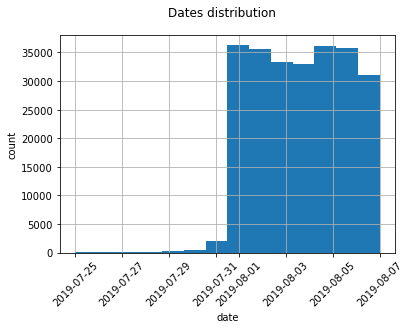

In [19]:
# Plotting the histogram for the dates
ax = events['date'].hist(bins = 14)
b = plt.xticks(rotation='45')
b = plt.xlabel("date")
b = plt.ylabel("count")
b = plt.suptitle("Dates distribution")

Mainly the events occured for the period from 01.08.2019 till 07.08.2019. We assume the previous data was gathered due to technical reasons and we'll ignore it not to skew the overall picture.



In [20]:
# make slice for dates from 1st of August
events = events[events['timestamp']>='2019-08-01']

Let's check the time distibution.

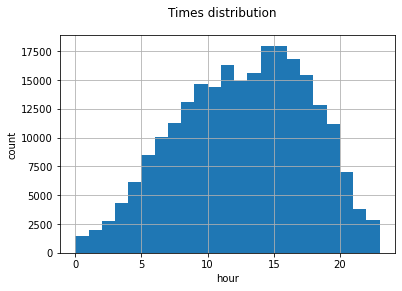

In [21]:
# Plotting the histogram for the time
ax = events['timestamp'].dt.hour.hist(bins=23)
b = plt.xticks()
b = plt.xlabel("hour")
b = plt.ylabel("count")
b = plt.suptitle("Times distribution")

In [22]:
# get statistics for the hours distribution
events['timestamp'].dt.hour.describe()

count    241298.000000
mean         12.215563
std           4.952312
min           0.000000
25%           9.000000
50%          13.000000
75%          16.000000
max          23.000000
Name: timestamp, dtype: float64

We see that max load hours last from ~14:00 to ~16:00 (2 hours) and the main activity lasts from ~09:00 to ~17:00

<a id='lose'>
<ul><li>Did you lose many events and users when excluding the older data?
</li></ul></a>   

[🔝 To contents](#top)

In [23]:
# Check events and users one more time
events_num_new = events.shape[0]
events_num_new

241298

In [24]:
# new number of users
users_num_new = events['user'].nunique()
users_num_new

7534

In [25]:
# Calculate the percentage of the lost users and events
print('We lost {:.2%} events and {:.2%} users'.format(
    (events_num - events_num_new)/events_num, 
     (users_num - users_num_new)/users_num))

We lost 1.16% events and 0.23% users


<a id='check'>
<ul><li>Make sure you have users from all three experimental groups.</li></ul></a>  

[🔝 To contents](#top)

In [26]:
# count for each group unique users
events.groupby('group')['user'].nunique()

group
246    2484
247    2513
248    2537
Name: user, dtype: int64

The number of users in each group is close to each other.

## Conclusion:
    
1. There're 5 event types and totally 244 126 events for all 3 groups.
2. The average number of events per user is ~32.
3. The data covers the period from 25.07.2019 to 07.08.2019 
4. Mainly the events occured for the period from 01.08.2019 till 07.08.2019. We assume the previous data was gathered due to technical reasons and we'll ignore it not to skew the overall picture.
5. We filterd out the data from 25.07.2019 to 31.07.2019. We lost 1.16% events and 0.23% users so we can drop this data.
6. The number of users in each group is close to each other and is around ~2500 users.    


### <a id='step4'>Step 4. Study the event funnel</a>

[🔝 To contents](#top)

<a id='step4.1'>
<ul><li>See what events are in the logs and their frequency of occurrence. Sort them by frequency.</li></ul></a> 


In [27]:
# check the frequencies for event names once again
events['event'].value_counts().sort_values(ascending=False)

MainScreenAppear           117431
OffersScreenAppear          46350
CartScreenAppear            42365
PaymentScreenSuccessful     34113
Tutorial                     1039
Name: event, dtype: int64

The most popular event is Main screen, the least popular is tutorial.

<a id='step4.2'>
<ul><li>Find the number of users who performed each of these actions. Sort the events by the number of users. Calculate the proportion of users who performed the action at least once.</li></ul></a> 

[🔝 To contents](#top)

In [28]:
# group by event and get unique users for each event
events_by_users  = events.groupby('event')['user'].nunique().sort_values(ascending=False)
events_by_users

event
MainScreenAppear           7419
OffersScreenAppear         4593
CartScreenAppear           3734
PaymentScreenSuccessful    3539
Tutorial                    840
Name: user, dtype: int64

Similar to previous calculations: Main screen is the leader while tutorial is the outsider.

In [29]:
# get the proportion of users for each action
events_by_users / users_num_new

event
MainScreenAppear           0.984736
OffersScreenAppear         0.609636
CartScreenAppear           0.495620
PaymentScreenSuccessful    0.469737
Tutorial                   0.111495
Name: user, dtype: float64

<a id='step4.3'>
<ul><li>In what order do you think the actions took place. Are all of them part of a single sequence? You don't need to take them into account when calculating the funnel.</li></ul></a> 

[🔝 To contents](#top)

From the above it's obvious that the first screen which almost all users supposed to see in the app is the Main screen. 

The overall event sequence is:

    MainScreenAppear → OffersScreenAppear → CartScreenAppear → PaymentScreenSuccessful

Tutorial is not in the chain of events as it's not mandatory for any step.

<a id='step4.4'>
<ul><li>Use the event funnel to find the share of users that proceed from each stage to the next. (For instance, for the sequence of events A → B → C, calculate the ratio of users at stage B to the number of users at stage A and the ratio of users at stage C to the number at stage B.)</li></ul></a>

[🔝 To contents](#top)

In [30]:
# First, let's look at a simple funnel (not sequenced events)
offer2main = events_by_users['OffersScreenAppear']/events_by_users['MainScreenAppear']
cart2offer = events_by_users['CartScreenAppear']/events_by_users['OffersScreenAppear']
pay2cart = events_by_users['PaymentScreenSuccessful']/events_by_users['CartScreenAppear']
print('Ratio of users at offer stage: {:>.2}'.format(offer2main))
print('Ratio of users at cart stage: {:>.2}'.format(cart2offer))
print('Ratio of users at successful payment stage: {:>.2}'.format(pay2cart))

Ratio of users at offer stage: 0.62
Ratio of users at cart stage: 0.81
Ratio of users at successful payment stage: 0.95


Now let's calculate the same for the sequenced events funnel


In [31]:
# define a function to get a sequenced events funnel
def get_funnel(events):
    # build a pivot table with user ids as rows and events as columns containing 
    # the first event date
    users = events.pivot_table(
    index='user', 
    columns='event', 
    values='timestamp',
    aggfunc='min') 
    
    # build conditions for each step
    step_1 = ~users['MainScreenAppear'].isna()
    step_2 = step_1 & (users['OffersScreenAppear'] > users['MainScreenAppear'])
    step_3 = step_2 & (users['CartScreenAppear'] > users['OffersScreenAppear'])
    step_4 = step_3 & (users['PaymentScreenSuccessful'] > users['CartScreenAppear'])

    # slice according the conditions and get the size
    n_main = users[step_1].shape[0]
    n_offer = users[step_2].shape[0]
    n_cart = users[step_3].shape[0]
    n_payment = users[step_4].shape[0]
    
    # separately get unique users for tutorial though it's out of scope
    n_tutorial = events[events['event']=='Tutorial']['user'].nunique()
    # build Series to return
    funnel = pd.Series({'MainScreenAppear':n_main, 'OffersScreenAppear':n_offer,
                       'CartScreenAppear':n_cart, 'PaymentScreenSuccessful':n_payment, 
                        'Tutorial':n_tutorial})
    return funnel

In [32]:
# call the function and get the values
funnel = get_funnel(events)
funnel

MainScreenAppear           7419
OffersScreenAppear         4201
CartScreenAppear           1767
PaymentScreenSuccessful     454
Tutorial                    840
dtype: int64

In [33]:
# Recalculate the ratios for the sequenced events
n_main = funnel.loc['MainScreenAppear']
n_offer = funnel.loc['OffersScreenAppear']
n_cart = funnel.loc['CartScreenAppear']
n_payment = funnel.loc['PaymentScreenSuccessful']

offer2main = n_offer/n_main
cart2offer = n_cart/n_offer
pay2cart = n_payment/n_cart

print('Ratio of users at offer stage: {:>.2}'.format(offer2main))
print('Ratio of users at cart stage: {:>.2}'.format(cart2offer))
print('Ratio of users at successful payment stage: {:>.2}'.format(pay2cart))


Ratio of users at offer stage: 0.57
Ratio of users at cart stage: 0.42
Ratio of users at successful payment stage: 0.26


<a id='step4.5'>
<ul><li>At what stage do you lose the most users?</li></ul></a>

[🔝 To contents](#top)

We see that we've got completely different numbers because the simple funnel does not take into account the sequence of events.

It's clear that we lose the most users at the last stage (we get just 26% conversion) though coversions to offer and cart screens are also not high.

<a id='step4.6'>
<ul><li>What share of users make the entire journey from their first event to payment?</li></ul></a>

[🔝 To contents](#top)

In [34]:
print('The share of users from the 1st event to payment: {:>.2}'.format(n_payment/users_num_new))

The share of users from the 1st event to payment: 0.06


Only 6% of users go through the entire journey from the main screen via offer and cart screens to the payment screen.

Now let's consider all unique users who reached the successful payment stage no matter what was their first event and event chain.
We just need to take users proportion from the simple funnel (already calculated above).    
    
Let's repeat that step here:    
 

In [35]:
# get the proportion of users for each action
events_by_users / users_num_new


event
MainScreenAppear           0.984736
OffersScreenAppear         0.609636
CartScreenAppear           0.495620
PaymentScreenSuccessful    0.469737
Tutorial                   0.111495
Name: user, dtype: float64

## Conclusion

We've got ~46.97% of users that somehow reached the last stage. 
    


1. The most popular event is Main screen as it's the first event in the sequence, the least popular is tutorial as it's an optional step.
2. The overall event sequence is:

    MainScreenAppear → OffersScreenAppear → CartScreenAppear → PaymentScreenSuccessful

Tutorial is not in the chain of events as it's not mandatory for any step.
3. We lose the most users at the last stage (we get just 26% conversion) though coversions to offer and cart screens are also not high. 
    
4. Only 6% of users go through the entire journey from the 1st Main screen to the last payment screen
5. We've got ~46.97% of users that somehow reached the last (payment stage) stage (not necessary going through the all screens in the chain).    


### <a id='step5'>Step 5. Study the results of the experiment</a>

[🔝 To contents](#top)

<a id='step5.1'>
<ul><li>How many users are there in each group?</li></ul></a>


In [36]:
# count unique users for each group
group_users = events.groupby('group')['user'].nunique()
group_users

group
246    2484
247    2513
248    2537
Name: user, dtype: int64

The number of users in each group is close to each other.

<a id='step5.2'>
<ul><li>We have two control groups in the A/A test, where we check our mechanisms and calculations. See if there is a statistically significant difference between samples 246 and 247.</li></ul></a>

[🔝 To contents](#top)

In [37]:
# Let's build a DF with rows as events and columns as groups
# values would be sequenced events funnel values for each group
groupA1 = get_funnel(events[events['group']==246])
groupA2 = get_funnel(events[events['group']==247])
groupB = get_funnel(events[events['group']==248])

frame = { 246: groupA1, 247: groupA2, 248:groupB } 
funnel_grouped = pd.DataFrame(frame)
funnel_grouped

,246,247,248
MainScreenAppear,2450,2476,2493
OffersScreenAppear,1411,1379,1411
CartScreenAppear,584,600,583
PaymentScreenSuccessful,145,144,165
Tutorial,278,283,279


It seems there're no serious differences between three groups though the problematic stage (payment) user count has increased in group B by ~20 users. It can be due to the size of group B (which is slightly larger than A groups). So taking the proportions we can result in the same share.

Let's make statistical tests. We'll create a function to make statistical test for proportions.

**$H_0$**: There's **_no_** difference in proportion of users that reach the stage we test.

**$H_a$**: There **_is_** a difference in proportion of users that reach the stage we test.


In [38]:
# implement function to make a statistical test for proportions beetween 
# two groups for a certain event
# function takes funnel DF, group ids, event name and a significance level
# it gets the values from the table funnel_grouped (see above)
def check_hypothesis(funnel_grouped, group1,group2, event, alpha=0.05):
    #let's start with successes, using 
    successes1=funnel_grouped.loc[event][group1]
    successes2=funnel_grouped.loc[event][group2]
    
    #for trials we use values from group_users (see above)
    trials1=group_users.loc[group1]
    trials2=group_users.loc[group2]
    
    #proportion for success in the first group
    p1 = successes1/trials1

   #proportion for success in the second group
    p2 = successes2/trials2

    # proportion in a combined dataset
    p_combined = (successes1 + successes2) / (trials1 + trials2)

# the difference between the datasets' proportions  
    difference = p1 - p2
    
# calculating the statistic in standard deviations of the standard normal 
# distribution    
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials1 + 1/trials2))

# setting up the standard normal distribution (mean 0, standard deviation 1
    distr = st.norm(0, 1) 


    p_value = (1 - distr.cdf(abs(z_value))) * 2

    print('p-value: ', p_value)
    
    if (p_value < alpha):
        print("Reject H0 for",event, 'and groups',group1,group2)
    else:
        print("Fail to Reject H0 for", event,'and groups',group1,group2)  

In [39]:
# check the function
check_hypothesis(funnel_grouped, 246,247, 'PaymentScreenSuccessful', alpha=0.05)

p-value:  0.8711113474158618
Fail to Reject H0 for PaymentScreenSuccessful and groups 246 247


We're going to make tests for each of the event types (totally 5) to compare the proportions. 
Let's set the familywise significance level $\alpha$ to 0.05 but for each particular test we'll need to apply a correction. Let's use the simplest **Bonferroni correction** and test each individual hypothesis at $\alpha_i = \alpha/5 = 0.05 / 5 = 0.01$ 


In [40]:
alpha = 0.05
alpha_i = alpha / funnel_grouped.shape[0]

for i in funnel_grouped.index:
    print('Event:', i)
    check_hypothesis(funnel_grouped, 246,247, i, alpha_i)
    print()

Event: MainScreenAppear
p-value:  0.7570597232046099
Fail to Reject H0 for MainScreenAppear and groups 246 247

Event: OffersScreenAppear
p-value:  0.1697911058352899
Fail to Reject H0 for OffersScreenAppear and groups 246 247

Event: CartScreenAppear
p-value:  0.7613480430769994
Fail to Reject H0 for CartScreenAppear and groups 246 247

Event: PaymentScreenSuccessful
p-value:  0.8711113474158618
Fail to Reject H0 for PaymentScreenSuccessful and groups 246 247

Event: Tutorial
p-value:  0.9376996189257114
Fail to Reject H0 for Tutorial and groups 246 247



### Conclusion:

There's no statistically significant difference between group A1 and group A2 based on **sequenced event funnel**.

<a id='step5.3'>
<ul><li>Select the most popular event. In each of the control groups, find the number of users who performed this action. Find their share. Check whether the difference between the groups is statistically significant. Repeat the procedure for all other events (it will save time if you create a special function for this test). Can you confirm that the groups were split properly?</li></ul></a>


[🔝 To contents](#top)

Above we saw that MainScreenAppear event is the most popular event. Let's find the number of users that performed this event for each of the control groups.

In [41]:
# find users number for Main screen event
main_A1 = funnel_grouped.loc['MainScreenAppear'][246]
main_A2 = funnel_grouped.loc['MainScreenAppear'][247]

#find group sizes
sizeA1 = group_users.loc[246]
sizeA2 = group_users.loc[247]

# find users' share
p1 = main_A1 / sizeA1
p2 = main_A2 / sizeA2

print("Group A1 share for Main screen", p1)
print("Group A2 share for Main screen", p2)

Group A1 share for Main screen 0.9863123993558777
Group A2 share for Main screen 0.9852765618782332


We already made a statistical test for the Main screen (see above), so let's repeat it. The only difference: we make a single hypothesis test now, so leave alpha = 0.05.

In [42]:
check_hypothesis(funnel_grouped,246,247, 'MainScreenAppear')

p-value:  0.7570597232046099
Fail to Reject H0 for MainScreenAppear and groups 246 247


In [43]:
# build a pivot table with rows as events and columns as groups
# calculate unique users for each event/group
pivot = events.pivot_table(index='event', values='user', columns='group', aggfunc=lambda x: x.nunique()).reset_index()
pivot

group,event,246,247,248
0,CartScreenAppear,1266,1238,1230
1,MainScreenAppear,2450,2476,2493
2,OffersScreenAppear,1542,1520,1531
3,PaymentScreenSuccessful,1200,1158,1181
4,Tutorial,278,283,279


In [44]:
simple_funnel_grouped = pivot.set_index('event')
simple_funnel_grouped

group,246,247,248
event,,,
CartScreenAppear,1266,1238,1230
MainScreenAppear,2450,2476,2493
OffersScreenAppear,1542,1520,1531
PaymentScreenSuccessful,1200,1158,1181
Tutorial,278,283,279


Now we're going to make tests not based on event chains but on event general popularity (simple funnel).

As above we need to adjust the significance level.

In [45]:
alpha = 0.05
alpha_i = alpha / simple_funnel_grouped.shape[0]

for i in simple_funnel_grouped.index:
    print('Event:', i)
    check_hypothesis(simple_funnel_grouped, 246,247, i, alpha_i)
    print()

Event: CartScreenAppear
p-value:  0.22883372237997213
Fail to Reject H0 for CartScreenAppear and groups 246 247

Event: MainScreenAppear
p-value:  0.7570597232046099
Fail to Reject H0 for MainScreenAppear and groups 246 247

Event: OffersScreenAppear
p-value:  0.2480954578522181
Fail to Reject H0 for OffersScreenAppear and groups 246 247

Event: PaymentScreenSuccessful
p-value:  0.11456679313141849
Fail to Reject H0 for PaymentScreenSuccessful and groups 246 247

Event: Tutorial
p-value:  0.9376996189257114
Fail to Reject H0 for Tutorial and groups 246 247



### Conclusion:

There's no statistically significant difference between group A1 and group A2 based on **simple funnel** so the groups were split properly.

<a id='step5.4'>
<ul><li>Do the same thing for the group with altered fonts. Compare the results with those of each of the control groups for each event in isolation. Compare the results with the combined results for the control groups. What conclusions can you draw from the experiment?</li></ul></a>

[🔝 To contents](#top)

In [46]:
# make tests for group A1 and group B.
alpha = 0.05
alpha_i = alpha / simple_funnel_grouped.shape[0]

for i in funnel_grouped.index:
    print('Event:', i)
    check_hypothesis(simple_funnel_grouped, 246,248, i, alpha_i)
    print()

Event: MainScreenAppear
p-value:  0.2949721933554552
Fail to Reject H0 for MainScreenAppear and groups 246 248

Event: OffersScreenAppear
p-value:  0.20836205402738917
Fail to Reject H0 for OffersScreenAppear and groups 246 248

Event: CartScreenAppear
p-value:  0.07842923237520116
Fail to Reject H0 for CartScreenAppear and groups 246 248

Event: PaymentScreenSuccessful
p-value:  0.2122553275697796
Fail to Reject H0 for PaymentScreenSuccessful and groups 246 248

Event: Tutorial
p-value:  0.8264294010087645
Fail to Reject H0 for Tutorial and groups 246 248



### Conclusion:

There's no statistically significant difference between group A1 and group B based on **simple funnel**.

In [47]:
# make tests for group A2 and group B.
alpha = 0.05
alpha_i = alpha / simple_funnel_grouped.shape[0]

for i in simple_funnel_grouped.index:
    print('Event:', i)
    check_hypothesis(simple_funnel_grouped, 247,248, i, alpha_i)
    print()

Event: CartScreenAppear
p-value:  0.5786197879539783
Fail to Reject H0 for CartScreenAppear and groups 247 248

Event: MainScreenAppear
p-value:  0.4587053616621515
Fail to Reject H0 for MainScreenAppear and groups 247 248

Event: OffersScreenAppear
p-value:  0.9197817830592261
Fail to Reject H0 for OffersScreenAppear and groups 247 248

Event: PaymentScreenSuccessful
p-value:  0.7373415053803964
Fail to Reject H0 for PaymentScreenSuccessful and groups 247 248

Event: Tutorial
p-value:  0.765323922474501
Fail to Reject H0 for Tutorial and groups 247 248



### Conclusion:

There's no statistically significant difference between group A2 and group B based on **simple funnel**.

<a id='step5.5'>
<ul><li>What significance level have you set to test the statistical hypotheses mentioned above? Calculate how many statistical hypothesis tests you carried out. With a statistical significance level of 0.1, one in 10 results could be false. What should the significance level be? If you want to change it, run through the previous steps again and check your conclusions.</li></ul></a>

[🔝 To contents](#top)

If we want to make conclusions for the overall tests meaning that 
there's no significant difference between A1 and A2 **AND** between A1 and B **AND** between A2 and B we need to make further adjustments for the significance level as the overall tests number increses 3 times (each group comparison had 5 tests and now we have 3 group comparisons each made of 5 tests totally getting 15 tests).

Let's make 15 tests for the sequenced events funnel (it contains the most valuable information). 

In [48]:
alpha = 0.05
group_comarisons = 3
alpha_i = alpha / (group_comarisons*funnel_grouped.shape[0])
pairs = [(246,247),(246,248),(247,248)]

for group1,group2 in pairs:
    print('Comparison for groups',group1,group2 )
    print()
    for i in funnel_grouped.index:
        print('Event:', i)
        check_hypothesis(funnel_grouped, group1,group2, i, alpha_i)
        print()
    print('=================================')

Comparison for groups 246 247

Event: MainScreenAppear
p-value:  0.7570597232046099
Fail to Reject H0 for MainScreenAppear and groups 246 247

Event: OffersScreenAppear
p-value:  0.1697911058352899
Fail to Reject H0 for OffersScreenAppear and groups 246 247

Event: CartScreenAppear
p-value:  0.7613480430769994
Fail to Reject H0 for CartScreenAppear and groups 246 247

Event: PaymentScreenSuccessful
p-value:  0.8711113474158618
Fail to Reject H0 for PaymentScreenSuccessful and groups 246 247

Event: Tutorial
p-value:  0.9376996189257114
Fail to Reject H0 for Tutorial and groups 246 247

Comparison for groups 246 248

Event: MainScreenAppear
p-value:  0.2949721933554552
Fail to Reject H0 for MainScreenAppear and groups 246 248

Event: OffersScreenAppear
p-value:  0.39679135492535766
Fail to Reject H0 for OffersScreenAppear and groups 246 248

Event: CartScreenAppear
p-value:  0.6563033863591861
Fail to Reject H0 for CartScreenAppear and groups 246 248

Event: PaymentScreenSuccessful
p-va

### Conclusion:
    
1. The number of users in each group is close to each other and is ~2500 users.
2. There's no statistically significant difference between group A1 and group A2 for simple and sequenced event funnels so the groups were split properly.
3. There's no statistically significant difference between group A1 and group B for the simple funnel.  
4. There's no statistically significant difference between group A2 and group B for the simple funnel.  
5. There's no significant difference between groups A1 and A2 AND between groups A1 and B AND between A2 and B groups for the event sequenced funnel.        
   


### <a id='con'>General conclusions</a>
[🔝 To contents](#top)

I. We've studied the sales funnel and got the following:

1. Based on assumptions we get several options:

    1.1. We lose the most of users at the last payment stage (we get just 26% conversion) though coversions to offer and cart screens are also not high. (if several different events per second are **not** allowed).
    
    1.2. We lose the most of users at the cart stage (we get just 43% conversion which is the minimal value).(if several different events per second **are** allowed)

2. Based on assumptions we get several options:

    2.1. Only 6% of users go through the entire journey from the 1st screen to the payment screen. (if several different events per second are **not** allowed)

    2.2. Only 18% of users go through the entire journey from the 1st screen to the payment screen. (if several different events per second **are** allowed)

II. We've analyzed the results of A/A/B tests and conclude:
1. The control groups A1 and A2 were split properly based on statistical tests for simple and event sequenced funnels.
2. There's no significant difference between A1 and B groups for the simple funnel. 
3. There's no significant difference between A2 and B groups for the simple funnel. 
4. There's no significant difference between A1 and A2 **AND** between A1 and B **AND** between A2 and B groups for the event sequenced funnel.
5. So we recommend not to implement the new fonts as there's no statistically significant difference between control and test groups.